In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

/kaggle/input/pii-1st-solution-datasets/external/external_data_v8.json
/kaggle/input/pii-1st-solution-datasets/piidd-balanced-cv-split/COMPETITION_FOLD_0.json
/kaggle/input/pii-1st-solution-datasets/piidd-balanced-cv-split/COMPETITION_FOLD_2.json
/kaggle/input/pii-1st-solution-datasets/piidd-balanced-cv-split/COMPETITION_FOLD_3.json
/kaggle/input/pii-1st-solution-datasets/piidd-balanced-cv-split/COMPETITION_FOLD_1.json
/kaggle/input/pii-1st-solution-datasets/processed/train_with_folds.json
/kaggle/input/pii-mixtral8x7b-generated-essays/mpware_mixtral8x7b_v1.1-no-i-username.json
/kaggle/input/pii-mixtral8x7b-generated-essays/mpware_mixtral8x7b_v1.1.json
/kaggle/input/notebook6c9120da18/fingerprint.pb
/kaggle/input/notebook6c9120da18/saved_model.pb
/kaggle/input/notebook6c9120da18/__results__.html
/kaggle/input/notebook6c9120da18/__notebook__.ipynb
/kaggle/input/notebook6c9120da18/__output__.json
/kaggle/input/notebook6c9120da18/custom.css
/kaggle/input/notebook6c9120da18/variables/varia

In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()

# Close TensorFlow session
tf.compat.v1.reset_default_graph()

# Optionally, release GPU memory
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

2024-05-11 03:17:55.297592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 03:17:55.297682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 03:17:55.423393: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_json('/kaggle/input/pii-detection-removal-from-educational-data/train.json')
df = df.drop('full_text', axis = 1)
print(len(df))
df.head()

6807


,document,tokens,trailing_whitespace,labels
0,7,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [4]:
def delete_condition(row_num):
    check = False
    temp = 0
    for label in df['labels'][row_num]:
        if label != "O":
            temp= temp + 1
            if(temp) >= 10:
                break
    return temp >= 10

def delete_condition2(row_num):
    check = False
    temp = 0
    for label in df2['labels'][row_num]:
        if label != "O":
            temp= temp + 1
            if(temp) >= 10:
                break
    return temp >= 10

def delete_condition3(row_num):
    check = False
    temp = 0
    for label in df3['labels'][row_num]:
        if label != "O":
            temp= temp + 1
            if(temp) >= 10:
                break
    return temp >= 10

In [5]:
mask = df.index.map(delete_condition)
df = df[mask]
df = df.reset_index(drop=True)
print(len(df))

26


In [6]:
df2 = pd.read_json('/kaggle/input/pii-mixtral8x7b-generated-essays/mpware_mixtral8x7b_v1.1-no-i-username.json')
df2 = df2.drop('full_text', axis = 1)
print(len(df2))
df2.head()

2692


,document,tokens,trailing_whitespace,labels
0,2cd5fb9799fe06349528c33423a0f595,"[Storytelling, Challenge, :, Crafting, Compell...","[True, False, True, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,3cb7ffeb0ef2f45672e53c38b29d610c,"[Storytelling, Challenge, :, The, Power, of, N...","[True, False, True, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,c172f453e4643ae9c9bc9d8426128217,"[Storytelling, Challenge, :, The, Power, of, N...","[True, False, True, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,b9edf42553f58bbffa457381a3799770,"[Storytelling, Challenge, :, Crafting, Compell...","[True, False, True, True, True, True, True, Fa...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,232dd2bd7be9d3a3ea93cab6e17fcbfa,"[Storytelling, Challenge, :, The, Power, of, N...","[True, False, True, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [7]:
df3 = pd.read_json('/kaggle/input/pii-dd-mistral-generated/mixtral-8x7b-v1.json')
df3 = df3.drop('full_text', axis = 1)
print(len(df3))
df3.head()

2355


,document,tokens,labels,trailing_whitespace
0,dtduupvzgt,"[Tiburce, Evans, ,, https://www.instagram.com/...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-URL_PERS...","[True, False, True, False, True, True, True, F..."
1,uejmzisyyh,"[Rose, -, Mai, Rodriguez, |, PIN, #, 3814374, ...","[B-NAME_STUDENT, I-NAME_STUDENT, I-NAME_STUDEN...","[False, False, True, True, True, True, True, F..."
2,jzevfvijlw,"[Lina, Wingate, ;, 095, Terry, Via, \n, Terrym...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-STREET_A...","[True, False, True, True, True, False, False, ..."
3,jqldfongxi,"[Lally, Scales, |, Pin, #, 74,7,9,0, ,, 658, -...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, B-ID...","[True, True, True, True, True, False, True, Fa..."
4,qzgtouvmtu,"[Li, Warfield, -, Fontana, ;, 001, -, 528, -, ...","[B-NAME_STUDENT, I-NAME_STUDENT, I-NAME_STUDEN...","[True, False, False, False, True, False, False..."


In [8]:
mask = df2.index.map(delete_condition2)
df2 = df2[mask]
df2 = df2.reset_index(drop=True)
print(len(df2))

974


In [9]:
mask = df3.index.map(delete_condition3)
df3 = df3[mask]
df3 = df3.reset_index(drop=True)
print(len(df3))

2144


In [10]:
df = pd.concat([df, df2, df3], ignore_index=True)
df = df.drop('trailing_whitespace', axis = 1)
print(len(df))
df.head()

3144


,document,tokens,labels
0,609,"[Date:14, -, 09, -, 2021, \n\n, NEWS, PAPER, \...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,2722,"[Guayaquil, ,, September, 24, ,, 2020, ., , N...","[O, O, O, O, O, O, O, O, O, O, B-NAME_STUDENT,..."
2,3427,"[Design, Thinking, :, Final, Assignment, , ...","[O, O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUD..."
3,3709,"[,, Vol.7, ,, No.5, ,, May, 2009, \n\n, E, -, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,3885,"[1, Leonardo, Torres, \n\n, Reflection, –, Lea...","[O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O..."


In [11]:
labels = ["B-EMAIL", "B-ID_NUM", "B-NAME_STUDENT", "B-PHONE_NUM",
                  "B-STREET_ADDRESS", "B-URL_PERSONAL", "B-USERNAME",
                  "I-ID_NUM", "I-NAME_STUDENT", "I-PHONE_NUM",
                  "I-STREET_ADDRESS","I-URL_PERSONAL","O"]
label2id = {label: i for i, label in enumerate(labels)}

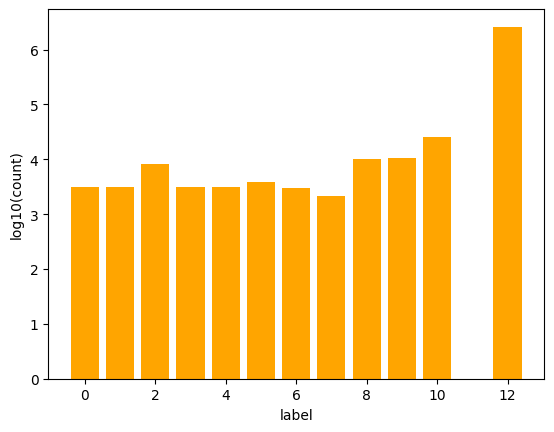

In [22]:
count = np.zeros(13)
for i in range(0,len(df)):
    for label in df['labels'][i]:
        count[label2id[label]] +=1
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12],np.log10(count), color = 'orange')
plt.ylabel('log10(count)')
plt.xlabel('label')
plt.show()

In [13]:
num_epochs = 6
input_size = 512
hidden_size = 256
num_classes = 13
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [14]:
import random

import tensorflow as tf
import tensorflow_hub as hub

use_model = tf.saved_model.load('/kaggle/input/notebook6c9120da18/')

In [15]:
import warnings
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import numpy as np

# Suppress warnings
warnings.filterwarnings('ignore')

# Function to process tokens and get embeddings
def process_tokens(tokens):
    return use_model(tokens).numpy()

# Initialize embeddings column
df['embeddings'] = pd.Series()

# Define function for processing tokens using ThreadPoolExecutor
def process_tokens_parallel(idx):
    tokens = df['tokens'][idx]
    embeddings =  process_tokens(tokens)
    return embeddings

# Define number of threads
num_threads = 8  # Adjust as needed based on your system specifications

# Process tokens in parallel using ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    embeddings_list = list(executor.map(process_tokens_parallel, range(len(df))))

# Assign embeddings to DataFrame
df['embeddings'] = embeddings_list

print(df.head())


  document                                             tokens  \
0      609  [Date:14, -, 09, -, 2021, \n\n, NEWS, PAPER, \...   
1     2722  [Guayaquil, ,, September, 24, ,, 2020, .,  , N...   
2     3427  [Design, Thinking, :, Final, Assignment,    , ...   
3     3709  [,, Vol.7, ,, No.5, ,, May, 2009, \n\n, E, -, ...   
4     3885  [1, Leonardo, Torres, \n\n, Reflection, –, Lea...   

                                              labels  \
0  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   
1  [O, O, O, O, O, O, O, O, O, O, B-NAME_STUDENT,...   
2  [O, O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUD...   
3  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   
4  [O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O...   

                                          embeddings  
0  [[-0.0073966933, -0.012820947, 0.040002137, -0...  
1  [[-0.05903982, -0.029179584, 0.043255627, -0.0...  
2  [[5.054705e-05, 0.024362098, 0.032928474, -0.0...  
3  [[-0.051991396, 0.014403126, -0.0028208615, -0...

In [16]:
class BiLSTMSoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTMSoftmax, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers, bidirectional=True, batch_first = True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        self.linear = nn.Linear(input_size,input_size)
        
    def forward(self, input_ids):
        lstm_out, _ = self.lstm(input_ids)
        outputs = torch.cat((lstm_out[:, -1, :self.hidden_size], lstm_out[:, 0, self.hidden_size:]), dim=1)
        output = self.fc(lstm_out)
        output = F.softmax(output, dim=-1)  # Aply softmax along the last dimension
        return output


In [17]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embeddings = self.data['embeddings'][idx]
        labels = self.data['labels'][idx]
        labels = [label2id[label] for label in labels]
        
        return torch.tensor(embeddings), labels
    
def custom_collate_fn(batch):
    embeddings_batch = [item[0] for item in batch]
    labels_batch = [item[1] for item in batch]

    # Pad embeddings to the maximum length in the batch
    max_length = max(len(embeddings) for embeddings in embeddings_batch)
    padded_embeddings_batch = []
    for embeddings in embeddings_batch:
        pad_size = max_length - len(embeddings)
        padded_embeddings_batch.append(torch.nn.functional.pad(embeddings, (0, 0, 0, pad_size)))

    padded_labels_batch = []
    for labels in labels_batch:
        pad_size = max_length - len(labels)
        padded_labels_batch.append(torch.nn.functional.pad(torch.tensor(labels), (0, pad_size), value=12))
        
    padded_embeddings_tensor = torch.stack(padded_embeddings_batch)
    padded_labels_tensor = torch.stack(padded_labels_batch)

    return padded_embeddings_tensor, padded_labels_tensor

In [18]:
weights = torch.ones(13).to(device)  # Initialize with 1
for i in range(0,13):
    weights[i] = 1e7/count[i]
print(weights)
# Define cross-entropy loss function with weighted class labels
def weighted_cross_entropy_loss(outputs, labels, weights):
    return F.cross_entropy(outputs, labels, weight=weights)

tensor([3.1807e+03, 3.1506e+03, 1.2261e+03, 3.2000e+03, 3.2373e+03, 2.5840e+03,
        3.2992e+03, 4.6555e+03, 9.6993e+02, 9.5749e+02, 3.9026e+02,        inf,
        3.8399e+00], device='cuda:0')


In [30]:
dataset = CustomDataset(df)
data_loader = DataLoader(dataset, batch_size=2, collate_fn=custom_collate_fn)
model = BiLSTMSoftmax(input_size, hidden_size, 2, num_classes).to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [27]:
import gc
gc.collect()

843

In [31]:
from sklearn.metrics import fbeta_score
from tqdm import tqdm

lss = []
epc = []
f1sc = []
for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    print(f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    true_labels = []
    predict_labels = []
    
    progress_bar = tqdm(data_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    
    for embedding_ids_tensor, label_ids_tensor in progress_bar:
        
       
        outputs = model(embedding_ids_tensor.to(device))
        
        outputs = outputs.view(-1, outputs.size(-1))
        label_ids_tensor = label_ids_tensor.view(-1).to(device) 
        loss = weighted_cross_entropy_loss(outputs, label_ids_tensor, weights)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
            
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == label_ids_tensor).sum().item()
        total_samples += label_ids_tensor.size(0)
        true_labels.extend(label_ids_tensor.cpu().numpy())
        predict_labels.extend(predicted_labels.cpu().numpy())
        # Update progress bar description
        progress_bar.set_postfix({'Loss': total_loss / total_samples})
        
       
    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / total_samples}")
    if true_labels:  # Check if true_labels is not empty
        f1 = fbeta_score(true_labels, predict_labels, beta=5,average='micro')
    else:
        f1 = None
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / total_samples}, F1 Score (beta=5): {f1}")
    
    lss.append(total_loss / total_samples)
    epc.append(epoch)
    f1sc.append(f1)

Epoch 1/6


Epoch 1/6, Loss: 0.0013471257465826271
Epoch 1/6, Loss: 0.0013471257465826271, F1 Score (beta=5): 0.7256265789858448
Epoch 2/6


Epoch 2/6, Loss: 0.0012643545055433828
Epoch 2/6, Loss: 0.0012643545055433828, F1 Score (beta=5): 0.8296198193113158
Epoch 3/6


Epoch 3/6, Loss: 0.0012070738533604955
Epoch 3/6, Loss: 0.0012070738533604955, F1 Score (beta=5): 0.8850494904742314
Epoch 4/6


Epoch 4/6, Loss: 0.0011582371501087088
Epoch 4/6, Loss: 0.0011582371501087088, F1 Score (beta=5): 0.9215228309027294
Epoch 5/6


Epoch 5/6, Loss: 0.001131457022098278
Epoch 5/6, Loss: 0.001131457022098278, F1 Score (beta=5): 0.9420153894803415
Epoch 6/6


Epoch 6/6, Loss: 0.0011074427997002296
Epoch 6/6, Loss: 0.0011074427997002296, F1 Score (beta=5): 0.9406168713043657


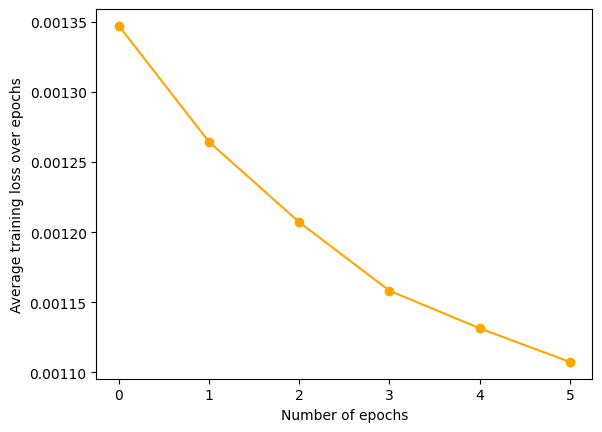

In [32]:
plt.plot(epc,lss, color = 'orange')
plt.scatter(epc,lss,color = 'orange')
plt.ylabel('Average training loss over epochs')
plt.xlabel('Number of epochs')
plt.show()

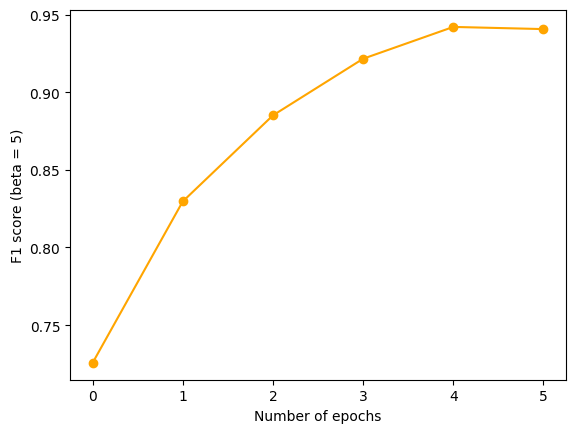

In [33]:
plt.plot(epc,f1sc, color = 'orange')
plt.scatter(epc,f1sc,color = 'orange')
plt.ylabel('F1 score (beta = 5)')
plt.xlabel('Number of epochs')
plt.show()

In [34]:
test_df = pd.read_json('/kaggle/input/pii-1st-solution-datasets/external/external_data_v8.json')
test_df = test_df.drop('full_text',axis = 1)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4659 entries, 0 to 4658
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   document             4659 non-null   object 
 1   tokens               4659 non-null   object 
 2   labels               4659 non-null   object 
 3   trailing_whitespace  4659 non-null   object 
 4   NAME_STUDENT         2304 non-null   object 
 5   EMAIL                972 non-null    object 
 6   USERNAME             880 non-null    object 
 7   ID_NUM               0 non-null      float64
 8   PHONE_NUM            0 non-null      float64
 9   URL_PERSONAL         562 non-null    object 
 10  STREET_ADDRESS       581 non-null    object 
 11  header               2304 non-null   object 
 12  context              2304 non-null   object 
 13  flavor               2304 non-null   object 
dtypes: float64(2), object(12)
memory usage: 546.0+ KB


In [36]:
def delete_condition4(row_num):
    check = False
    temp = 0
    for label in test_df['labels'][row_num]:
        if label != "O":
            temp= temp + 1
            if(temp) >= 10:
                break
    return temp >= 10

In [37]:
mask = test_df.index.map(delete_condition4)
test_df = test_df[mask]
test_df = test_df.reset_index(drop=True)
print(len(test_df))

2324


In [38]:
import warnings
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import numpy as np

# Suppress warnings
warnings.filterwarnings('ignore')

# Function to process tokens and get embeddings
def process_tokens(tokens):
    return use_model(tokens).numpy()

# Initialize embeddings column
test_df['embeddings'] = pd.Series()

# Define function for processing tokens using ThreadPoolExecutor
def process_tokens_parallel(idx):
    tokens = test_df['tokens'][idx]
    embeddings =  process_tokens(tokens)
    return embeddings

# Define number of threads
num_threads = 8  # Adjust as needed based on your system specifications

# Process tokens in parallel using ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    embeddings_list = list(executor.map(process_tokens_parallel, range(len(test_df))))

# Assign embeddings to DataFrame
test_df['embeddings'] = embeddings_list

print(test_df.head())

     document                                             tokens  \
0  dtduupvzgt  [Tiburce, Evans, ,, https://www.instagram.com/...   
1  uejmzisyyh  [Rose, -, Mai, Rodriguez, |, PIN, #, 3814374, ...   
2  jzevfvijlw  [Lina, Wingate, ;, 095, Terry, Via, \n, Terrym...   
3  jqldfongxi  [Lally, Scales, |, Pin, #, 74,7,9,0, ,, 658, -...   
4  qzgtouvmtu  [Li, Warfield, -, Fontana, ;, 001, -, 528, -, ...   

                                              labels  \
0  [B-NAME_STUDENT, I-NAME_STUDENT, O, B-URL_PERS...   
1  [B-NAME_STUDENT, I-NAME_STUDENT, I-NAME_STUDEN...   
2  [B-NAME_STUDENT, I-NAME_STUDENT, O, B-STREET_A...   
3  [B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, B-ID...   
4  [B-NAME_STUDENT, I-NAME_STUDENT, I-NAME_STUDEN...   

                                 trailing_whitespace NAME_STUDENT EMAIL  \
0  [True, False, True, False, True, True, True, F...          NaN   NaN   
1  [False, False, True, True, True, True, True, F...          NaN   NaN   
2  [True, False, True, True, 

In [39]:
dataset = CustomDataset(test_df)
data_loader = DataLoader(dataset, batch_size=4, collate_fn=custom_collate_fn)

In [40]:
correct_predictions = 0

true_labels = []
predict_labels = []

progress_bar = tqdm(data_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
with torch.no_grad():
    for embedding_ids_tensor, label_ids_tensor in progress_bar:

        outputs = model(embedding_ids_tensor.to(device))

        outputs = outputs.view(-1, outputs.size(-1))
        label_ids_tensor = label_ids_tensor.view(-1).to(device) 

        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == label_ids_tensor).sum().item()
        total_samples += label_ids_tensor.size(0)
        true_labels.extend(label_ids_tensor.cpu().numpy())
        predict_labels.extend(predicted_labels.cpu().numpy())


    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}")
    if true_labels:  # Check if true_labels is not empty
        f1 = fbeta_score(true_labels, predict_labels, beta=5,average='micro')
    else:
        f1 = None
    print(f"Epoch {epoch+1}/{num_epochs}, F1 Score (beta=5): {f1}")

Epoch 6/6
Epoch 6/6, F1 Score (beta=5): 0.9718317199661664


In [ ]:
id2label = ["B-EMAIL", "B-ID_NUM", "B-NAME_STUDENT", "B-PHONE_NUM",
                  "B-STREET_ADDRESS", "B-URL_PERSONAL", "B-USERNAME",
                  "I-ID_NUM", "I-NAME_STUDENT", "I-PHONE_NUM",
                  "I-STREET_ADDRESS","I-URL_PERSONAL","O"]

In [ ]:
test_df = pd.read_json('/kaggle/input/pii-detection-removal-from-educational-data/test.json')
test_df = test_df.drop('full_text',axis = 1)
test_df.info()

In [ ]:
# Initialize embeddings column
test_df['embeddings'] = pd.Series()
# Define function for processing tokens using ThreadPoolExecutor
def process_tokens_parallel(idx):
    tokens = test_df['tokens'][idx]
    embeddings =  process_tokens(tokens)
    return embeddings

# Define number of threads
num_threads = 8  # Adjust as needed based on your system specifications

# Process tokens in parallel using ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    embeddings_list = list(executor.map(process_tokens_parallel, range(len(test_df))))

# Assign embeddings to DataFrame
test_df['embeddings'] = embeddings_list

print(test_df.head())

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embeddings = self.data['embeddings'][idx]
        document_id = self.data['document'][idx]
        return torch.tensor(embeddings), document_id

In [ ]:

# Create dataset
test_dataset = CustomTestDataset(test_df)

# Data loader for batching
test_data_loader = DataLoader(test_dataset, batch_size=1)

predictions = []

# Make predictions
for batch in test_data_loader:
    # Move batch to device
    embeddings = batch[0].to(device)
    document_id = batch[1]
    # Perform forward pass
    with torch.no_grad():
        outputs = model(embeddings)

    # Apply softmax to get probabilities
    probabilities = F.softmax(outputs, dim=2)
    
    # Get predicted labels
    _, predicted_labels = torch.max(probabilities, dim=2)
    
    # Post-process predictions
    predicted_labels = predicted_labels.squeeze().cpu().numpy().tolist()
    predicted_labels = [id2label[label] for label in predicted_labels]

    # Get corresponding tokens

    # Add predictions to list
    for idx, token_label in enumerate(predicted_labels):
        if token_label != 'O':  # Exclude tokens with 'O' label
            predictions.append((document_id.item(), idx, token_label))

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions, columns=['document', 'token', 'label'])

# Add row_id column
predictions_df['row_id'] = predictions_df.index

# Reorder columns
predictions_df = predictions_df[['row_id', 'document', 'token', 'label']]

# Save predictions to CSV
predictions_df.to_csv('predicted_labels.csv', index=False, header=True)
print(predictions_df.head())